In [1]:
import sys
import os
import textwrap
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import KFold, GridSearchCV
from lightgbm import LGBMRegressor
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import root_mean_squared_error

import subprocess
import clus_util

In [2]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
#Features concerned with generation settings. Will be used as indepedent variants in relation to model accuracy
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]
targets=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict = dict(zip(targets, target_names))
target_names_dict_w = dict(zip(targets, target_names_w))

In [21]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [4]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[targets]

In [5]:
cv_result_path="experiment_result/Q4_result.csv"

cv_result_df=pd.DataFrame()
if Path(cv_result_path).is_file():
    cv_result_df=pd.read_csv(cv_result_path,header=0,index_col=0)

In [6]:
#Permutation of metadataset to transform some of generation settings into categorical features

config_df=pd.read_csv("artifact/metadataset.csv")
config_df=config_df[config_key+bias_score_key]

#"n_sample" transform into "dataset size" which partitioned into: ">15k","10k-15k","5k-10k","<=5k"
size=config_df["n_samples"]
conditions  = [ size>15000,(size <=15000) & (size>10000)
               , (size <=10000) & (size> 5000),size <=5000]
choices     = [">15k","10k-15k","5k-10k","<=5k"]
config_df["dataset_size"]=np.select(conditions,choices)
config_df["dataset_size"]=config_df["dataset_size"].astype("category")
choices.reverse()
config_df["dataset_size"]=config_df["dataset_size"].cat.set_categories(choices)

#"n_informative" and "n_features" are transformed into "Info/feature" which represent the ratio between "n_informative" and "n_features"
#"Info/feature" also partitioned into four section ">0.8","0.8-0.4","0.4-0.2","<=0.2"
config_df["Info/feature"]=config_df["n_informative"]/config_df["n_features"]
info_feature=config_df["Info/feature"]
conditions  = [ info_feature>0.8,(info_feature <=0.8) & (info_feature>0.4)
               , (info_feature <=0.4) & (info_feature> 0.2),info_feature <=0.2]
choices     = [">0.8","0.8-0.4","0.4-0.2","<=0.2"]
config_df["Info/feature"]=np.select(conditions,choices)
config_df["Info/feature"]=config_df["Info/feature"].astype("category")
choices.reverse()
config_df["Info/feature"]=config_df["Info/feature"].cat.set_categories(choices)

#"continous_groups" and "sensitive_imbalanced" are grouped into "(continous_groups,sensitive_imbalanced)" since they are related to 
# how the SSR representation ends up
config_df["(continous_groups,sensitive_imbalanced)"]=config_df[["continous_groups","sensitive_imbalanced"]].apply(
    lambda row: "("+','.join(row.values.astype(str))+")", axis=1)
config_df["(continous_groups,sensitive_imbalanced)"]=config_df["(continous_groups,sensitive_imbalanced)"].astype("category")
config_df["(continous_groups,sensitive_imbalanced)"]=config_df["(continous_groups,sensitive_imbalanced)"].cat.set_categories(
    ["(False,False)","(False,True)","(True,False)","(True,True)"])

#"n_informative" are transformed into "informative_features" which partitioned into: ">16","12-16","8-12","4-8","<=4"
informative=config_df["n_informative"]
conditions  = [ informative>16,(informative <=16) & (informative> 12), (informative <=12) & (informative>8)
               , (informative <=8) & (informative> 4),informative <=4]
choices     = [">16","12-16","8-12","4-8","<=4"]
config_df["informative_features"]=np.select(conditions,choices)
config_df["informative_features"]=config_df["informative_features"].astype("category")
choices.reverse()
config_df["informative_features"]=config_df["informative_features"].cat.set_categories(choices)
config_df

,dataset_random_state,n_samples,n_informative,n_redundant,n_repeated,n_classes,class_imbalanced,n_clusters_per_class,positive_class_num,sensitive_random_state,...,Group Size Disparity,Prevalence Disparity,equal_opportunity,disparate_parity,individual_fairness,group_fairness,dataset_size,Info/feature,"(continous_groups,sensitive_imbalanced)",informative_features
0,70,14700,5,16,7,6,False,1,2,175,...,0.556054,0.173098,0.174348,0.329953,1.089688,1.089688,10k-15k,<=0.2,"(False,True)",4-8
1,70,14700,5,16,7,6,False,1,2,196,...,0.894830,0.073208,0.059953,0.161977,1.089688,1.089688,10k-15k,<=0.2,"(True,True)",4-8
2,70,14700,5,16,7,6,False,1,2,537,...,0.808413,0.073757,0.061024,0.120686,1.089688,1.365560,10k-15k,<=0.2,"(True,True)",4-8
3,70,14700,5,16,7,6,False,1,2,502,...,0.951004,0.072282,0.097669,0.154956,1.089688,1.252137,10k-15k,<=0.2,"(True,True)",4-8
4,140,10100,3,2,3,3,False,1,1,1257,...,0.777635,0.151507,0.290602,0.245546,0.145200,0.145200,10k-15k,<=0.2,"(False,True)",<=4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,349930,7700,2,0,0,4,True,1,1,4998839,...,0.263348,0.267915,0.663997,0.659069,0.234706,0.234706,5k-10k,>0.8,"(False,True)",<=4
19998,350000,9700,2,0,0,4,True,1,1,4999461,...,0.807835,0.081658,0.838179,0.182150,0.138746,0.138746,5k-10k,>0.8,"(True,True)",<=4
19999,350000,9700,2,0,0,4,True,1,1,4999093,...,0.432136,0.074126,0.128961,0.098755,0.138746,0.138746,5k-10k,>0.8,"(False,True)",<=4
20000,350000,9700,2,0,0,4,True,1,1,4999064,...,1.242069,0.131964,0.601413,0.220159,0.138746,0.138746,5k-10k,>0.8,"(False,True)",<=4


In [7]:
stage3_result_df=pd.read_csv(cv_result_path,index_col=0).sort_values("Dataset_Index")

def get_stage3_result(bs):
    result_df=stage3_result_df[stage3_result_df["Bias_Metrics"]==bs].drop(["Dataset_Index","Bias_Metrics"],axis=1)
    config_setting=config_df.drop([b for b in bias_score_key if b!=bs],axis=1)
    return pd.concat([config_setting,result_df],axis=1)

# Correlations and Feature Importance

In [6]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#cdcdcd', '#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [7]:
df_res = pd.read_csv(cv_result_path,index_col=0).sort_values("Dataset_Index")
df_res = df_res.drop("Dataset_Index", axis=1)
df_meta = pd.read_csv("artifact/metadataset.csv")

# exclude random states because they do not carry information
df_meta = df_meta.drop('dataset_random_state', axis=1)
df_meta = df_meta.drop('sensitive_random_state', axis=1)
df_meta = df_meta.drop('landmarking_random_state', axis=1)

# exclude arrays of class- or group-specific information as their shape is 
#  dataset-specific and does not generalize
df_meta = df_meta.drop('class_weight', axis=1)
df_meta = df_meta.drop('sensitive_group_scores', axis=1)

features = df_meta.columns[:-6]

In [8]:
def join_result(metric):
    df = df_meta.drop(bias_score_key,axis=1)
    result_df = df_res[['Bias_Metrics', metric]]
    result_df['Bias_Metrics'] = result_df['Bias_Metrics'].replace(target_names_dict)
    for bs in target_names:
        df_bs = result_df[result_df['Bias_Metrics'] == bs]
        df_bs.rename(columns={metric: bs}, inplace=True)
        df = pd.concat([df,df_bs.drop('Bias_Metrics', axis=1)],axis=1)
    return df

In [9]:
# join characteristics and results into one dataframe
df = join_result('RMSE')

In [10]:
# correlation matrix between descriptors and bias score prediction RMSE
non_target_names = [col for col in df.columns if col not in target_names]
corr = df.corr()[target_names].loc[non_target_names]

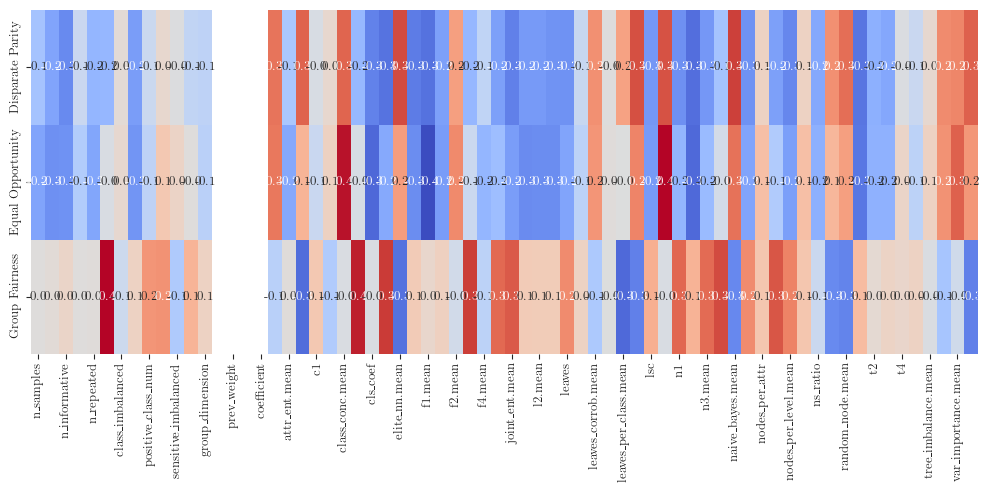

In [11]:
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
sns.heatmap(
    corr.T, 
    annot=True,  # Display the correlation coefficients
    cmap="coolwarm",  # Colormap for visual distinction
    fmt=".1f",  # Format for the annotations
    cbar=False,  # Include the color bar
    # square=True,  # Ensure the cells are square
    # yticklabels=corr.columns,  # Label columns on x-axis
    # xticklabels=corr.index  # Label rows on y-axis
)

plt.tight_layout()  # Adjust layout to fit elements
plt.show()

In [12]:
config_key=["n_samples","n_informative","n_classes",
            "n_clusters_per_class", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", 
            "n_features"]

In [13]:
config_dict = {
    "n_samples": '\# Samples',
    "n_informative": '\# Informative Features',
    "n_classes": '\# Classes',
    "n_clusters_per_class": '\# Clusters per Class', 
    "continous_groups": 'SSR Representation Type', 
    "sensitive_imbalanced": 'Biased Sampling',
    "n_group": '\# Sensitive Groups', 
    "group_dimension": 'Dimensionality of Sensitive Groups', 
    "n_features": '\# Features'
}

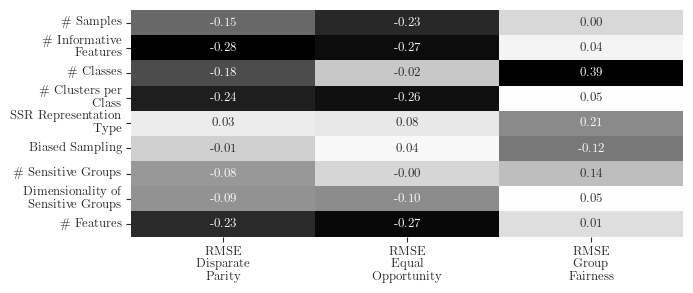

In [ ]:
custom_cmap = LinearSegmentedColormap.from_list("CustomDiverging", ['black', 'white', 'black'])

plt.figure(figsize=(7, 3))  # Adjust figure size as needed
sns.heatmap(
    corr.loc[config_key],
    annot=True,  # Display the correlation coefficients
    cmap=custom_cmap,  # Colormap for visual distinction
    fmt=".2f",  # Format for the annotations
    cbar=False,  # Include the color bar
    # yticklabels=[target_names_dict[label] for label in corr.index],
    yticklabels=[textwrap.fill(config_dict[label], width=20, break_long_words=False) for label in corr.loc[config_key].index],
    xticklabels=['RMSE\n'+textwrap.fill(label, width=10, break_long_words=False) for label in corr.columns],
)

plt.tight_layout()  # Adjust layout to fit elements
plt.xticks(rotation=0, ha='center');
plt.savefig(f"plots/Q4/dataset_characteristics_Pearson.pdf",bbox_inches="tight")
plt.show()

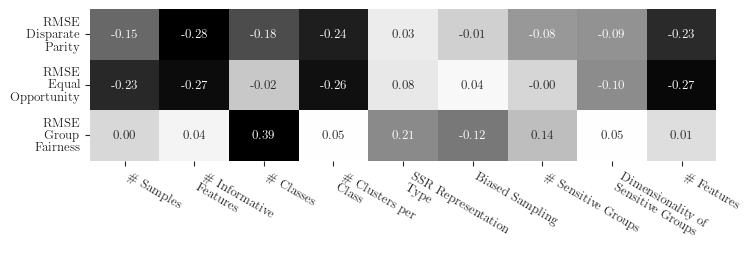

In [ ]:
custom_cmap = LinearSegmentedColormap.from_list("CustomDiverging", ['black', 'white', 'black'])

plt.figure(figsize=(7, 3))  # Adjust figure size as needed
sns.heatmap(
    corr.loc[config_key].T,
    annot=True,  # Display the correlation coefficients
    cmap=custom_cmap,  # Colormap for visual distinction
    fmt=".2f",  # Format for the annotations
    cbar=False,  # Include the color bar
    # yticklabels=[target_names_dict[label] for label in corr.index],
    xticklabels=[textwrap.fill(config_dict[label], width=20, break_long_words=False) for label in corr.loc[config_key].index],
    yticklabels=['RMSE\n'+textwrap.fill(label, width=10, break_long_words=False) for label in corr.columns],
)

plt.tight_layout()  # Adjust layout to fit elements
plt.xticks(rotation=330, ha='left');
plt.yticks(rotation=0, ha='right');
plt.savefig(f"plots/Q4/dataset_characteristics_Pearson.pdf",bbox_inches="tight")
plt.show()

#### Predictive Performance per Bias Score Level

In [16]:
def get_performance_per_score_level(metric):
    df = pd.DataFrame(columns=['Bias Score', 'Score Value', 'Score Category', metric])
    df_data = df_meta[targets].rename(columns=target_names_dict)
    df_result = df_res[['Bias_Metrics', metric]]
    df_result['Bias_Metrics'] = df_result['Bias_Metrics'].replace(target_names_dict)
    for bs in target_names:
        add_this = pd.DataFrame({
            'Bias Score': bs,
            'Score Value': df_data[bs],
            'Score Category': pd.qcut(df_data[bs], q=3, labels=['low', 'medium', 'high']),
            metric: df_result[df_result['Bias_Metrics'] == bs][metric]
        })
        df = pd.concat([df,add_this],ignore_index=True)
    return df

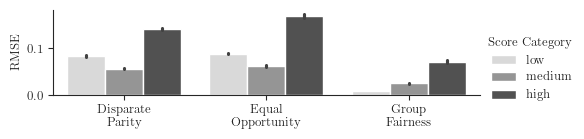

In [ ]:
df = get_performance_per_score_level('RMSE')

g = sns.catplot(df, x='Bias Score', hue='Score Category', y='RMSE', kind='bar',
           aspect=5/1.5, height=1.5, palette='Grays')
new_labels = [textwrap.fill(label.get_text(), width=10, break_long_words=False) for label in g.ax.get_xticklabels()]
g.ax.set_xticklabels(new_labels)
g.ax.set_xlabel("")
plt.savefig('Plots/Q4/RMSE_per_bias_score_level.pdf', bbox_inches='tight')
plt.show()

#### Feature Importance: Info Gain

In [19]:
lightGBM_params={
    "objective":"regression", 
    "n_jobs":8, 
    "random_state":700, 
    "device_type":"gpu",
    "verbosity":-1,
    "n_estimators":50,
    "max_depth":5,
    "learning_rate":0.01,
    "importance_type":"gain"
}

In [20]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y.loc[sample]
    # X_sam, Y_sam = X.loc[sample].reset_index(), Y.loc[sample].reset_index()
    for index, bs in enumerate(tqdm(targets, total=len(targets), desc=f"Seed {seed}"), start=1):
        best_model=LGBMRegressor(**lightGBM_params)
        best_model.fit(X_sam,Y_sam[bs])
        models[(bs, seed)] = best_model

Seed 9: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.17it/s]


In [21]:
# average feature importance over all seeds
avg_fis = {}
for bs in targets:
    avg_fi = np.array([models[(bs, seed)].feature_importances_ for seed in range(10)])
    avg_fis[bs] = np.mean(avg_fi, axis=0)

In [25]:
# Sort features based on group size disparity
sorted_indices = np.argsort(avg_fis[targets[1]])[::-1]  
sorted_features = X.columns[sorted_indices]

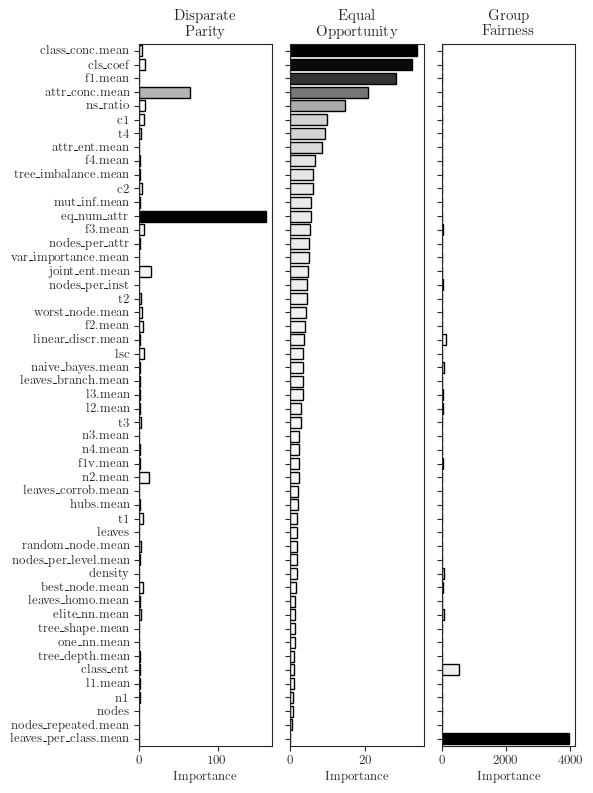

In [26]:
# Create a single figure with 6 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(6, 8), sharey=True)

for i, bs in enumerate(targets):
    # Get feature importances for this bs, sorted by overall ranking
    sorted_importances = avg_fis[bs][sorted_indices]

    sns.barplot(x=sorted_importances, y=sorted_features, ax=axes[i], palette="Grays", 
                hue=sorted_importances, legend=False, edgecolor='black')
    
    axes[i].set_title(target_names_dict_w[bs])
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_detailed.pdf', bbox_inches='tight')
plt.show()

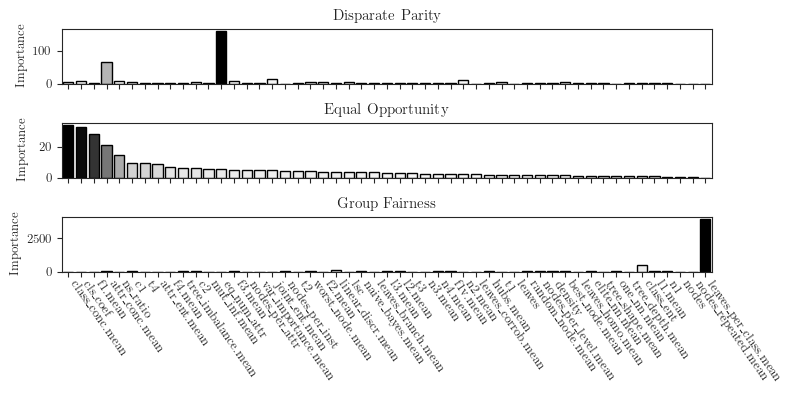

In [27]:
# Create a single figure with 6 subplots in a row
fig, axes = plt.subplots(3,1, figsize=(8, 4), sharex=True)

for i, bs in enumerate(targets):
    # Get feature importances for this bs, sorted by overall ranking
    sorted_importances = avg_fis[bs][sorted_indices]

    sns.barplot(y=sorted_importances, x=sorted_features, ax=axes[i], palette="Grays", 
                hue=sorted_importances, legend=False, edgecolor='black')
    
    axes[i].set_title(target_names_dict[bs])
    axes[i].set_ylabel("Importance")
    axes[i].set_xlabel("")
    
axes[1].set_ylabel("Importance", labelpad=8.5)
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_detailed_gain.pdf', bbox_inches='tight')
plt.show()

In [57]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['group_fairness'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['group_fairness'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['leaves_per_class.mean']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('group_fairness', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

Seed: 0  | RMSE all:  0.2701426081612178  | RMSE without:  0.2735730173728353  | Increase (in %):  1.2698512222737712
Seed: 1  | RMSE all:  0.2738213095880231  | RMSE without:  0.27759109405651977  | Increase (in %):  1.376731589724883
Seed: 2  | RMSE all:  0.2767322999742725  | RMSE without:  0.2806874540259732  | Increase (in %):  1.4292346979620456
Seed: 3  | RMSE all:  0.2745012954301008  | RMSE without:  0.27917092525410253  | Increase (in %):  1.7011321628501335
Seed: 4  | RMSE all:  0.27877739458690787  | RMSE without:  0.2808449465738925  | Increase (in %):  0.74164979913393
Seed: 5  | RMSE all:  0.27158899278328  | RMSE without:  0.27537534446395545  | Increase (in %):  1.3941476942317845
Seed: 6  | RMSE all:  0.2799239489276486  | RMSE without:  0.2817536237693648  | Increase (in %):  0.653632834462875
Seed: 7  | RMSE all:  0.2748028094119709  | RMSE without:  0.27751512258350425  | Increase (in %):  0.9870034361501735
Seed: 8  | RMSE all:  0.27576399025852133  | RMSE without

In [58]:
# average feature importance over all seeds
avg_fi = np.array([models[('group_fairness', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(["leaves_per_class.mean"], axis=1).columns[sorted_indices]

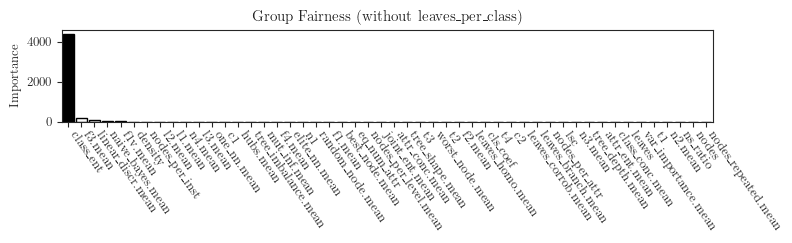

In [59]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title('Group Fairness (without leaves\_per\_class)')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig('Plots/Q4/feature_importance_group_fitness_without_leaves_per_class.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.2701438320760609  | RMSE without:  0.27919500964644606  | Increase (in %):  3.350503137838337
Seed: 1  | RMSE all:  0.27382138129862765  | RMSE without:  0.2827069788405437  | Increase (in %):  3.2450342262445404
Seed: 2  | RMSE all:  0.2767326864362299  | RMSE without:  0.28350003454279304  | Increase (in %):  2.4454458899355993
Seed: 3  | RMSE all:  0.2745008238480058  | RMSE without:  0.2810902154312192  | Increase (in %):  2.4004997474477685
Seed: 4  | RMSE all:  0.2787766941570403  | RMSE without:  0.2844040474360019  | Increase (in %):  2.0185881377126815
Seed: 5  | RMSE all:  0.2715856362152135  | RMSE without:  0.28070692602110237  | Increase (in %):  3.3585317445363256
Seed: 6  | RMSE all:  0.27992457174801655  | RMSE without:  0.2861324183310701  | Increase (in %):  2.2176854801591936
Seed: 7  | RMSE all:  0.27480296805278853  | RMSE without:  0.28212392072218756  | Increase (in %):  2.6640733618250816
Seed: 8  | RMSE all:  0.27576662916940864  | RMSE 

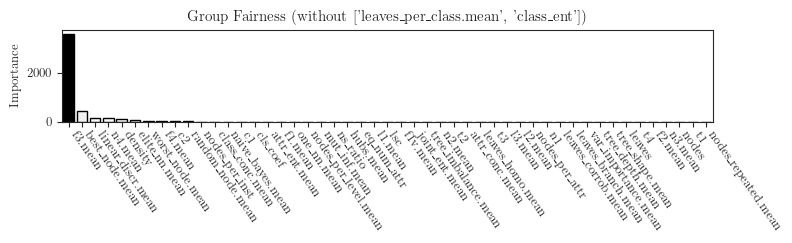

In [61]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['group_fairness'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['group_fairness'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['leaves_per_class.mean', 'class_ent']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('group_fairness', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('group_fairness', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_group_fitness_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.27014227928491696  | RMSE without:  0.2892460670122734  | Increase (in %):  7.071750404240803
Seed: 1  | RMSE all:  0.273824032306434  | RMSE without:  0.2922347938708485  | Increase (in %):  6.723574044739506
Seed: 2  | RMSE all:  0.2767339722421858  | RMSE without:  0.2925237969784519  | Increase (in %):  5.705777504775407
Seed: 3  | RMSE all:  0.27450230525080477  | RMSE without:  0.2917496012885159  | Increase (in %):  6.283115189853426
Seed: 4  | RMSE all:  0.27877607276948374  | RMSE without:  0.29411021651237557  | Increase (in %):  5.500523624770131
Seed: 5  | RMSE all:  0.2715827678283303  | RMSE without:  0.2925135723045887  | Increase (in %):  7.706970749148902
Seed: 6  | RMSE all:  0.2799245716981698  | RMSE without:  0.2969172015327873  | Increase (in %):  6.070431663619678
Seed: 7  | RMSE all:  0.27480212232238027  | RMSE without:  0.2943876130994389  | Increase (in %):  7.127125006000565
Seed: 8  | RMSE all:  0.2757658128967407  | RMSE without:  0

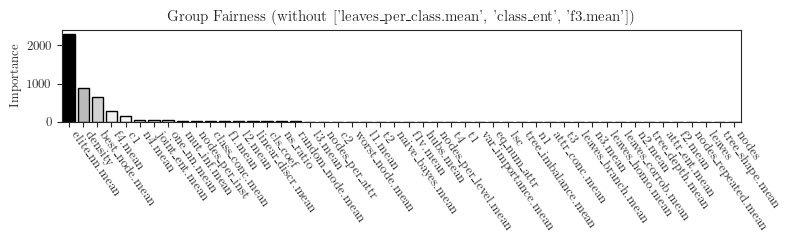

In [62]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['group_fairness'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['group_fairness'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['leaves_per_class.mean', 'class_ent', 'f3.mean']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('group_fairness', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('group_fairness', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_group_fitness_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.2701422232790926  | RMSE without:  0.28898809883670395  | Increase (in %):  6.976279135061786
Seed: 1  | RMSE all:  0.27382130946753963  | RMSE without:  0.2927643433808568  | Increase (in %):  6.918027654660222
Seed: 2  | RMSE all:  0.27673236682431457  | RMSE without:  0.2936024238614639  | Increase (in %):  6.096163318640426
Seed: 3  | RMSE all:  0.2745018735278722  | RMSE without:  0.2927715798267762  | Increase (in %):  6.655585284028653
Seed: 4  | RMSE all:  0.2787777948088186  | RMSE without:  0.29252318881650125  | Increase (in %):  4.9305914113816085
Seed: 5  | RMSE all:  0.2715899973480366  | RMSE without:  0.29370162450631054  | Increase (in %):  8.141546954668714
Seed: 6  | RMSE all:  0.27992457172766505  | RMSE without:  0.29568205460077934  | Increase (in %):  5.629188883226922
Seed: 7  | RMSE all:  0.2748029095022869  | RMSE without:  0.2930038578816546  | Increase (in %):  6.623273535324861
Seed: 8  | RMSE all:  0.27576849088628363  | RMSE withou

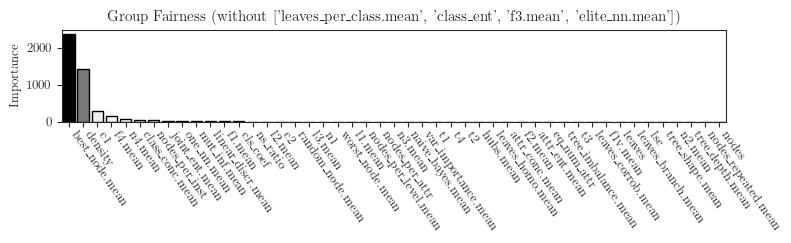

In [63]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['group_fairness'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['group_fairness'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['leaves_per_class.mean', 'class_ent', 'f3.mean', 'elite_nn.mean']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('group_fairness', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('group_fairness', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_group_fitness_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.14444965349670308  | RMSE without:  0.14514514994259095  | Increase (in %):  0.48148017600038484
Seed: 1  | RMSE all:  0.1453918390037319  | RMSE without:  0.14606281220028447  | Increase (in %):  0.4614930254340814
Seed: 2  | RMSE all:  0.14499200413607946  | RMSE without:  0.14493352618162947  | Increase (in %):  -0.04033184781355883
Seed: 3  | RMSE all:  0.14468949082851484  | RMSE without:  0.14568785157186745  | Increase (in %):  0.6900022507756675
Seed: 4  | RMSE all:  0.14312925044847896  | RMSE without:  0.14397457505112013  | Increase (in %):  0.5906022703203159
Seed: 5  | RMSE all:  0.14323778813434349  | RMSE without:  0.143421006679686  | Increase (in %):  0.1279121576288685
Seed: 6  | RMSE all:  0.14577374801766366  | RMSE without:  0.14611211114925188  | Increase (in %):  0.23211527191248504
Seed: 7  | RMSE all:  0.14456755092452475  | RMSE without:  0.14466786520325847  | Increase (in %):  0.06938920808452545
Seed: 8  | RMSE all:  0.14752194100488

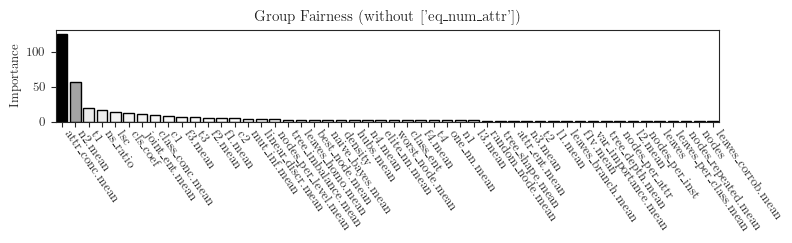

In [64]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['disparate_parity'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['disparate_parity'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['eq_num_attr']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('disparate_parity', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('disparate_parity', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_disparate_parity_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.1444496534984754  | RMSE without:  0.14529108198340376  | Increase (in %):  0.5825064058995707
Seed: 1  | RMSE all:  0.14539183900559383  | RMSE without:  0.14609427273306663  | Increase (in %):  0.4831314689167533
Seed: 2  | RMSE all:  0.14499200413646807  | RMSE without:  0.14637626885912725  | Increase (in %):  0.9547179728313111
Seed: 3  | RMSE all:  0.14468949083469462  | RMSE without:  0.14619775945353264  | Increase (in %):  1.0424175315961184
Seed: 4  | RMSE all:  0.1431292504468391  | RMSE without:  0.1437512820866803  | Increase (in %):  0.43459435293573145
Seed: 5  | RMSE all:  0.14323778813522411  | RMSE without:  0.1432564150118001  | Increase (in %):  0.013004163788390475
Seed: 6  | RMSE all:  0.14577406920931496  | RMSE without:  0.1462745364407847  | Increase (in %):  0.34331704821323383
Seed: 7  | RMSE all:  0.14456755092602486  | RMSE without:  0.14528816109347215  | Increase (in %):  0.4984591374976149
Seed: 8  | RMSE all:  0.14752169701990178

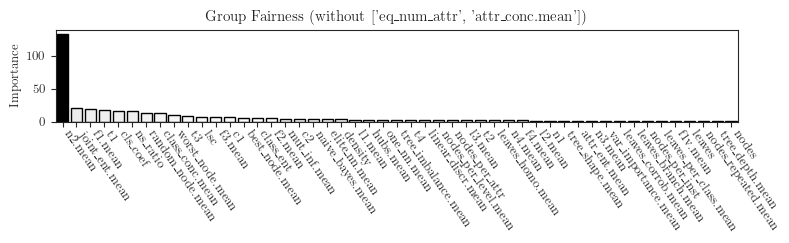

In [65]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['disparate_parity'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['disparate_parity'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['eq_num_attr', 'attr_conc.mean']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('disparate_parity', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('disparate_parity', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_disparate_parity_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

Seed: 0  | RMSE all:  0.14444962383229087  | RMSE without:  0.14499927885074637  | Increase (in %):  0.3805167530887159
Seed: 1  | RMSE all:  0.1453925666240104  | RMSE without:  0.14628450929622974  | Increase (in %):  0.6134719903019068
Seed: 2  | RMSE all:  0.1449920041353129  | RMSE without:  0.14606873865080183  | Increase (in %):  0.7426164786880726
Seed: 3  | RMSE all:  0.1446894908283736  | RMSE without:  0.14674615872737998  | Increase (in %):  1.4214355771325093
Seed: 4  | RMSE all:  0.14312925044936747  | RMSE without:  0.14290047756060234  | Increase (in %):  -0.1598365729205452
Seed: 5  | RMSE all:  0.14323778813412655  | RMSE without:  0.14356448021812723  | Increase (in %):  0.22807674445152237
Seed: 6  | RMSE all:  0.14577374802048412  | RMSE without:  0.14602716852350858  | Increase (in %):  0.17384508971316903
Seed: 7  | RMSE all:  0.14456755092757168  | RMSE without:  0.14493146996786954  | Increase (in %):  0.25172940812989897
Seed: 8  | RMSE all:  0.147521697014958

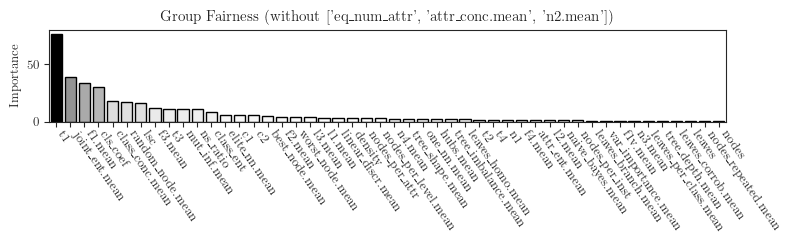

In [67]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
incs = []
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y['disparate_parity'].loc[sample]
    mask = np.full(len(Y),True,dtype=bool)
    mask[sample] = False
    Y_test = np.array(Y['disparate_parity'].loc[mask]).reshape(-1,1)
    
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    rmse_all = root_mean_squared_error(Y_test, best_model.predict(X.loc[mask]).reshape(-1,1))
    
    # drop overused feature
    drop_this = ['eq_num_attr', 'attr_conc.mean', 'n2.mean']
    X_sam = X_sam.drop(drop_this, axis=1)
    best_model=LGBMRegressor(**lightGBM_params)
    best_model.fit(X_sam,Y_sam)
    models[('disparate_parity', seed)] = best_model
    rmse_without = root_mean_squared_error(Y_test, best_model.predict(X.drop(drop_this, axis=1).loc[mask]).reshape(-1,1))
    inc = (rmse_without-rmse_all)/rmse_all*100
    incs.append(inc)
    print('Seed:', seed, ' | RMSE all: ', rmse_all, ' | RMSE without: ', rmse_without, ' | Increase (in %): ', inc)
print('Average increase (in %): ', np.average(incs))

# average feature importance over all seeds
avg_fi = np.array([models[('disparate_parity', seed)].feature_importances_ for seed in range(10)])
avg_fi = np.mean(avg_fi, axis=0)

sorted_indices = np.argsort(avg_fi)[::-1]  
sorted_features = X.drop(drop_this, axis=1).columns[sorted_indices]

fig, ax = plt.subplots(1, 1, figsize=(8,2.5))
sns.barplot(y=avg_fi[sorted_indices], x=sorted_features, palette="Grays", 
            hue=avg_fi[sorted_indices], legend=False, edgecolor='black')
ax.set_ylabel("Importance")
ax.set_xlabel("")
ax.set_title(f'Group Fairness (without {drop_this})')
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig(f'Plots/Q4/feature_importance_disparate_parity_without_{drop_this}.pdf', bbox_inches='tight')
plt.show()

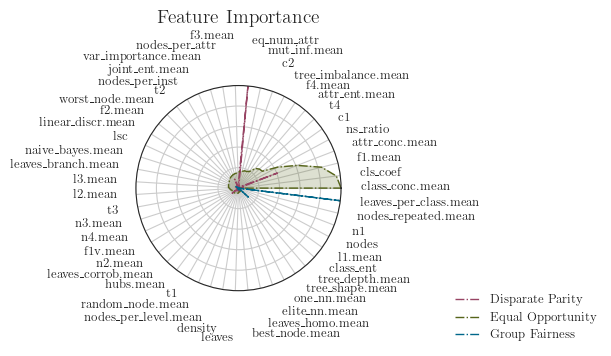

In [48]:
# Convert avg_fis to DataFrame and sort features by bs[0]
feature_importance_df = pd.DataFrame(avg_fis, index=X.columns)
sorted_features = feature_importance_df[targets[1]].sort_values(ascending=False).index
feature_importance_df = feature_importance_df.loc[sorted_features]
feature_importance_df.columns = [target_names_dict[col] for col in feature_importance_df.columns]

# Compute angles for radar chart (one per feature)
num_vars = len(sorted_features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(6.8, 6), subplot_kw=dict(polar=True))
# colors = plt.cm.viridis(np.linspace(0, 1, len(bias_score_key)))
colors = [COLORS[i] for i in [2, 4, 1, 5, 6, 3]]

# Plot each bs separately, scaled to its own max
for i, bs in enumerate(feature_importance_df.columns):
    values = feature_importance_df[bs].values
    max_val = values.max()  # Unique max per bs
    scaled_values = values / max_val  # Normalize to [0, 1] within bs
    scaled_values = np.append(scaled_values, scaled_values[0])

    ax.plot(angles, scaled_values, label=bs, color=colors[i], linewidth=1, linestyle='dashdot')
    ax.fill(angles, scaled_values, color=colors[i], alpha=0.2)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(sorted_features)#, rotation=90, ha="center")
for angle, label in zip(angles[:-1], ax.get_xticklabels()):
    # label.set_rotation(np.degrees(angle))  # Rotate based on angle
    label.set_verticalalignment("center")
    label.set_horizontalalignment("center")
    if (angle < 0.48*np.pi) or (angle > 1.52*np.pi):  # Right side
        label.set_horizontalalignment("left")
    elif (angle > 0.48*np.pi) and (angle < 1.52*np.pi):  # Left side
        label.set_horizontalalignment("right")
    if np.isclose(angle, 0.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(0.5*np.pi)))*0.6) 
    if np.isclose(angle, 1.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(1.5*np.pi)))*0.6) 
ax.set_yticklabels([])  # Hide radial labels
ax.set_ylim(0, 1)  # Now 0 to 1 per bs
ax.set_title("Feature Importance", fontsize=14, fontweight="bold")
ax.legend(title="", loc="lower left", bbox_to_anchor=(1.5, -0.3), frameon=False)

plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance.pdf', bbox_inches='tight')
plt.show()


#### Feature Importance: Split

(split = number of times the feature is used in a model)

In [49]:
lightGBM_params={
    "objective":"regression", 
    "n_jobs":8, 
    "random_state":700, 
    "device_type":"gpu",
    "verbosity":-1,
    "n_estimators":50,
    "max_depth":5,
    "learning_rate":0.01,
    "importance_type":"split"
}

In [50]:
# Train a single LightGBM on all data points to extract feature importance
models = {}
for seed in list(range(10)):
    np.random.seed(seed)
    sample = np.random.choice(list(range(len(X))), 1000)
    X_sam, Y_sam = X.loc[sample], Y.loc[sample]
    # X_sam, Y_sam = X.loc[sample].reset_index(), Y.loc[sample].reset_index()
    for index, bs in enumerate(tqdm(targets, total=len(targets), desc=f"Seed {seed}"), start=1):
        best_model=LGBMRegressor(**lightGBM_params)
        best_model.fit(X_sam,Y_sam[bs])
        models[(bs, seed)] = best_model

Seed 9: 100%|███████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.94it/s]


In [51]:
# average feature importance over all seeds
avg_fis = {}
for bs in targets:
    avg_fi = np.array([models[(bs, seed)].feature_importances_ for seed in range(10)])
    avg_fis[bs] = np.mean(avg_fi, axis=0)

In [87]:
# Sort features based on group size disparity
sorted_indices = np.argsort(avg_fis[targets[0]])[::-1]  
sorted_features = X.columns[sorted_indices]

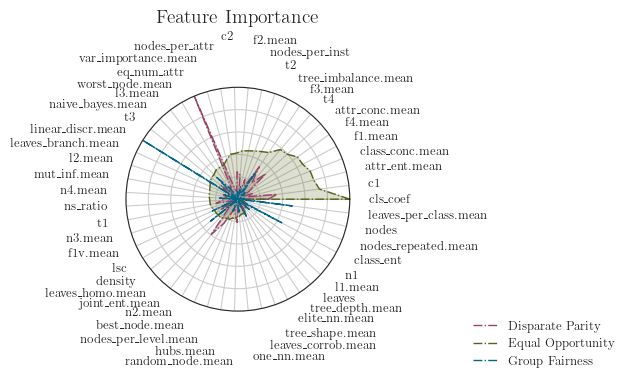

In [53]:
# Convert avg_fis to DataFrame and sort features by bs[0]
feature_importance_df = pd.DataFrame(avg_fis, index=X.columns)
sorted_features = feature_importance_df[targets[1]].sort_values(ascending=False).index
feature_importance_df = feature_importance_df.loc[sorted_features]
feature_importance_df.columns = [target_names_dict[col] for col in feature_importance_df.columns]

# Compute angles for radar chart (one per feature)
num_vars = len(sorted_features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(6.8, 6), subplot_kw=dict(polar=True))
# colors = plt.cm.viridis(np.linspace(0, 1, len(bias_score_key)))
colors = [COLORS[i] for i in [2, 4, 1, 5, 6, 3]]

# Plot each bs separately, scaled to its own max
for i, bs in enumerate(feature_importance_df.columns):
    values = feature_importance_df[bs].values
    max_val = values.max()  # Unique max per bs
    scaled_values = values / max_val  # Normalize to [0, 1] within bs
    scaled_values = np.append(scaled_values, scaled_values[0])

    ax.plot(angles, scaled_values, label=bs, color=colors[i], linewidth=1, linestyle='dashdot')
    ax.fill(angles, scaled_values, color=colors[i], alpha=0.2)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(sorted_features)#, rotation=90, ha="center")
for angle, label in zip(angles[:-1], ax.get_xticklabels()):
    # label.set_rotation(np.degrees(angle))  # Rotate based on angle
    label.set_verticalalignment("center")
    label.set_horizontalalignment("center")
    if (angle < 0.48*np.pi) or (angle > 1.52*np.pi):  # Right side
        label.set_horizontalalignment("left")
    elif (angle > 0.48*np.pi) and (angle < 1.52*np.pi):  # Left side
        label.set_horizontalalignment("right")
    if np.isclose(angle, 0.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(0.5*np.pi)))*0.6) 
    if np.isclose(angle, 1.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(1.5*np.pi)))*0.6) 
ax.set_yticklabels([])  # Hide radial labels
ax.set_ylim(0, 1)  # Now 0 to 1 per bs
ax.set_title("Feature Importance", fontsize=14, fontweight="bold")
ax.legend(title="", loc="lower left", bbox_to_anchor=(1.5, -0.3), frameon=False)

plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_splits.pdf', bbox_inches='tight')
plt.show()

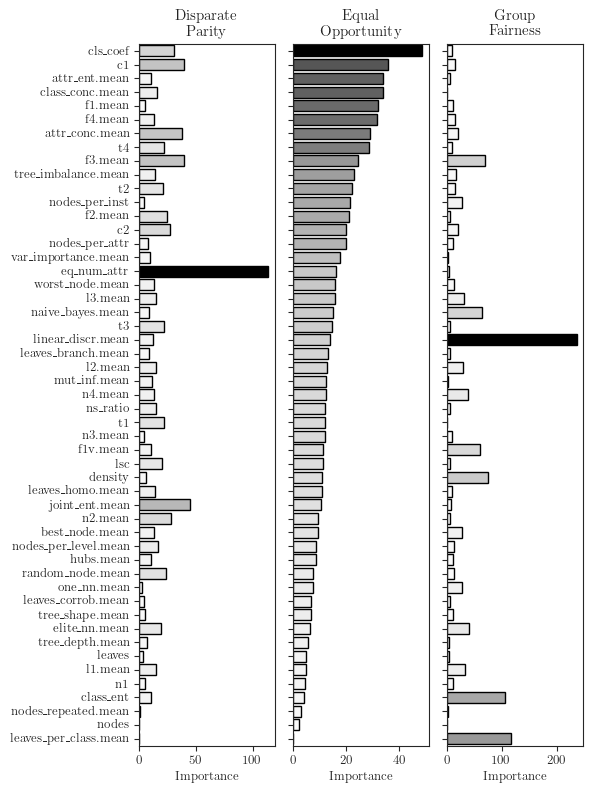

In [54]:
# Create a single figure with 6 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(6, 8), sharey=True)

for i, bs in enumerate(targets):
    # Get feature importances for this bs, sorted by overall ranking
    sorted_importances = avg_fis[bs][sorted_indices]

    sns.barplot(x=sorted_importances, y=sorted_features, ax=axes[i], palette="Grays", 
                hue=sorted_importances, legend=False, edgecolor='black')
    
    axes[i].set_title(target_names_dict_w[bs])
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_detailed_splits.pdf', bbox_inches='tight')
plt.show()

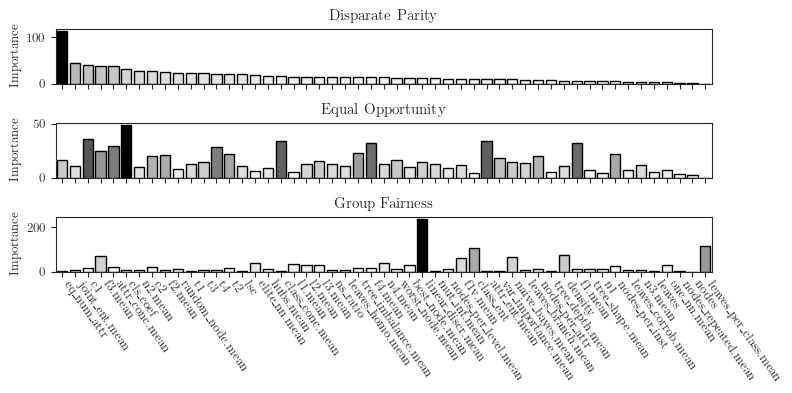

In [90]:
# Create a single figure with 6 subplots in a row
fig, axes = plt.subplots(3,1, figsize=(8, 4), sharex=True)

for i, bs in enumerate(targets):
    # Get feature importances for this bs, sorted by overall ranking
    sorted_importances = avg_fis[bs][sorted_indices]

    sns.barplot(y=sorted_importances, x=sorted_features, ax=axes[i], palette="Grays", 
                hue=sorted_importances, legend=False, edgecolor='black')
    
    axes[i].set_title(target_names_dict[bs])
    axes[i].set_ylabel("Importance")
    axes[i].set_xlabel("")
    
axes[1].set_ylabel("Importance", labelpad=8.5)
plt.xticks(rotation=305, ha='left');
plt.gca().tick_params(axis='x', pad=2)
plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_detailed_splits.pdf', bbox_inches='tight')
plt.show()

# Feature Importance with CLUS

In [9]:
# train CLUS on the entire dataset
Y_true, Y_pred, importances = clus_util.run_clus(X, Y, [0], seed=42, 
                                                 n_trees=3, tempdir="test", appendix='_all', debugmode=False)
importances.index =  X.columns

# Sort features based on overall importance
sorted_indices = np.argsort(importances['overAll'])[::-1]  
sorted_features = X.columns[sorted_indices]

In [13]:
importances

,overAll,target1,target2,target3
attr_conc.mean,48.898696,37.095370,40.918037,68.682680
attr_ent.mean,17.059707,8.780299,13.933924,28.464897
best_node.mean,16.715302,10.247355,17.184238,22.714312
c1,15.408243,8.444534,14.535924,23.244272
c2,6.289715,5.063792,6.019605,7.785749
class_conc.mean,12.601802,14.650063,12.073031,11.082310
class_ent,285.483034,7.081060,4.110430,845.257612
cls_coef,10.146681,6.906766,13.214985,10.318292
density,24.098652,6.329245,7.419907,58.546804
elite_nn.mean,6.949191,4.207323,7.739635,8.900616


In [19]:
# Sort features based on overall importance
sorted_indices = np.argsort(importances['overAll'])[::-1]  
sorted_features = X.columns[sorted_indices]
feature_importance_df = importances.loc[sorted_features]

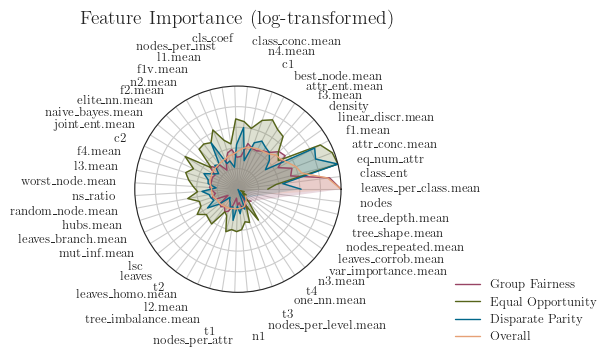

In [48]:
# Compute angles for radar chart (one per feature)
num_vars = len(sorted_features)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart loop

# Initialize radar plot
fig, ax = plt.subplots(figsize=(6.8, 6), subplot_kw=dict(polar=True))
# colors = plt.cm.viridis(np.linspace(0, 1, len(bias_score_key)))
colors = [COLORS[i] for i in [2, 4, 1, 5, 3, 6]]

# Plot each bs separately, scaled to its own max
for i, bs in enumerate(feature_importance_df.columns[::-1]):
    values = np.log(feature_importance_df[bs].values)
    # values = feature_importance_df[bs].values
    max_val = values.max()  # Unique max per bs
    scaled_values = values / max_val  # Normalize to [0, 1] within bs
    scaled_values = np.append(scaled_values, scaled_values[0])
    l = target_names[int(bs[-1])-1] if i<3 else 'Overall'

    ax.plot(angles, scaled_values, label=l, color=colors[i], linewidth=1)#, linestyle='dashdot')
    ax.fill(angles, scaled_values, color=colors[i], alpha=0.2)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(sorted_features)#, rotation=90, ha="center")
for angle, label in zip(angles[:-1], ax.get_xticklabels()):
    # label.set_rotation(np.degrees(angle))  # Rotate based on angle
    label.set_verticalalignment("center")
    label.set_horizontalalignment("center")
    if (angle < 0.48*np.pi) or (angle > 1.52*np.pi):  # Right side
        label.set_horizontalalignment("left")
    elif (angle > 0.48*np.pi) and (angle < 1.52*np.pi):  # Left side
        label.set_horizontalalignment("right")
    if np.isclose(angle, 0.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(0.5*np.pi)))*0.6) 
    if np.isclose(angle, 1.5*np.pi, atol=0.5):
        label.set_y(label.get_position()[1] - (0.5-np.abs(label.get_position()[0]-(1.5*np.pi)))*0.6) 
ax.set_yticklabels([])  # Hide radial labels
ax.set_ylim(0, 1)  # Now 0 to 1 per bs
ax.set_title("Feature Importance (log-transformed)", fontsize=14, fontweight="bold")
ax.legend(title="", loc="lower left", bbox_to_anchor=(1.5, -0.3), frameon=False)

plt.tight_layout()
plt.savefig('Plots/Q4/Feature_importance_splits_CLUS_log_trafo.pdf', bbox_inches='tight')
plt.show()